# SentiVista: Comparing Classical ML and Transformer-based Models

This notebook implements and compares different sentiment analysis approaches:
1. Classical ML models (Naive Bayes, Logistic Regression)
2. Fine-tuned RoBERTa transformer model

All models are evaluated on the Sentiment140 dataset using the same metrics for fair comparison.

## Setup and Import Libraries

In [11]:
# Install required libraries
!pip install datasets emoji evaluate transformers==4.40.0 tqdm matplotlib seaborn joblib

# Import common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from tqdm import tqdm
import joblib
import emoji
import torch

# NLP and ML libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Transformer-specific imports
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import evaluate

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

print("Setup complete!")

Setup complete!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\queri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\queri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\queri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Loading and Preprocessing

In [12]:
# Load Sentiment140 Dataset
df = pd.read_csv('sentiment140.csv', encoding='ISO-8859-1')
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

# Display dataset info
print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['target'].value_counts()}")
df.head()

Dataset shape: (1599999, 6)
Target distribution:
target
4    800000
0    799999
Name: count, dtype: int64


,target,id,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [13]:
# Common preprocessing function for both classical and transformer models
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_tweet(tweet):
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = re.sub(r'\d', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    tokens = tweet.split()
    tokens = [lemmatizer.lemmatize(stemmer.stem(word)) for word in tokens if word.lower() not in stop_words]
    tweet = ' '.join(tokens)
    return tweet

# Preprocess the text
df['cleaned_text'] = df['text'].apply(clean_tweet)

# Add target mapping for RoBERTa (0=negative, 1=neutral, 2=positive)
def map_target(val):
    if val == 0:
        return 0  # negative
    elif val == 2:
        return 1  # neutral
    else:  # val == 4 in original dataset
        return 2  # positive

df['label'] = df['target'].apply(map_target)

# Sample the dataset for faster experimentation (comment out for full training)
sampled_df = df.groupby('label').apply(lambda x: x.sample(n=10000, random_state=42)).reset_index(drop=True)
print(f"Sampled dataset shape: {sampled_df.shape}")
print(f"Sampled target distribution:\n{sampled_df['label'].value_counts()}")

# Display examples
sampled_df[['text', 'cleaned_text', 'target', 'label']].head()

Sampled dataset shape: (20000, 8)
Sampled target distribution:
label
0    10000
2    10000
Name: count, dtype: int64


C:\Users\queri\AppData\Local\Temp\ipykernel_37952\712547628.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label').apply(lambda x: x.sample(n=10000, random_state=42)).reset_index(drop=True)


,text,cleaned_text,target,label
0,@dickiemaxx Win a few; lose few a with a,win lose,0,0
1,@lavjonas tokio hotel and won tokio hotel that...,tokio hotel tokio hotel bad,0,0
2,"Right, off to work Only 5 hours to go until I...",right work hour go free xd,0,0
3,@daibarnes and guess who's landed that plum jo...,guess land plum job moi host big conf juli st ...,0,0
4,@rabbit_rabid can't sleep... come give me hug...,sleep come give hug,0,0


## Common Train-Test Split

We'll create a common train-test split that will be used by all models for fair comparison.

In [14]:
# Create a common train/test split for consistent evaluation
train_df, test_df = train_test_split(
    sampled_df, 
    test_size=0.2, 
    stratify=sampled_df['label'], 
    random_state=42
)

print(f"Train set: {train_df.shape}, Test set: {test_df.shape}")
print(f"Train label distribution:\n{train_df['label'].value_counts()}")
print(f"Test label distribution:\n{test_df['label'].value_counts()}")

Train set: (16000, 8), Test set: (4000, 8)
Train label distribution:
label
2    8000
0    8000
Name: count, dtype: int64
Test label distribution:
label
2    2000
0    2000
Name: count, dtype: int64


## Part 1: Classical ML Models

### Feature Engineering for Classical Models

In [15]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_text'])

# Additional features
train_df['tweet_length'] = train_df['text'].apply(len)
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([word for word in x.split() if word.startswith('#')]))
train_df['mention_count'] = train_df['text'].apply(lambda x: len([word for word in x.split() if word.startswith('@')]))

test_df['tweet_length'] = test_df['text'].apply(len)
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len([word for word in x.split() if word.startswith('#')]))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([word for word in x.split() if word.startswith('@')]))

# Combine TF-IDF with additional features
from scipy.sparse import hstack
X_train_additional = train_df[['tweet_length', 'hashtag_count', 'mention_count']].values
X_test_additional = test_df[['tweet_length', 'hashtag_count', 'mention_count']].values

X_train_combined = hstack([X_train_tfidf, X_train_additional])
X_test_combined = hstack([X_test_tfidf, X_test_additional])

# Target values
y_train_classical = train_df['target']  # Original 0/4 targets for classical models
y_test_classical = test_df['target']

print(f"Feature matrix shapes - Train: {X_train_combined.shape}, Test: {X_test_combined.shape}")

Feature matrix shapes - Train: (16000, 10003), Test: (4000, 10003)


### Train Classical Models

In [16]:
# Define a dictionary to store all models and their results
models = {}
results = {}

# Train Naive Bayes
print("Training Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train_combined, y_train_classical)
models['Naive Bayes'] = nb_model

# Train Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, solver='liblinear')
lr_model.fit(X_train_combined, y_train_classical)
models['Logistic Regression'] = lr_model

print("Classical models training complete!")

Training Naive Bayes...
Training Logistic Regression...
Classical models training complete!


## Part 2: RoBERTa Transformer Model

### Prepare Data for RoBERTa

In [17]:
# Set up tokenizer for RoBERTa
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['cleaned_text'], truncation=True, padding='max_length', max_length=128)

# Convert to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df[['cleaned_text', 'label']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['cleaned_text', 'label']].reset_index(drop=True))

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print("Data preparation for RoBERTa complete!")

c:\Users\queri\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Data preparation for RoBERTa complete!


### Train RoBERTa Model

In [18]:
# Load the pre-trained model
roberta_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  # Reduced for demonstration, increase for better results
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    save_total_limit=1,
    report_to='none'  # Disable wandb reporting
)

# Define metrics
accuracy_metric = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# Create Trainer
trainer = Trainer(
    model=roberta_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
print("Training RoBERTa model...")
trainer.train()

models['RoBERTa'] = trainer.model
print("RoBERTa model training complete!")

c:\Users\queri\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Training RoBERTa model...


  0%|          | 0/500 [00:00<?, ?it/s]

{'loss': 0.6029, 'grad_norm': 9.252849578857422, 'learning_rate': 4e-05, 'epoch': 0.2}
{'loss': 0.5432, 'grad_norm': 5.744284629821777, 'learning_rate': 3e-05, 'epoch': 0.4}
{'loss': 0.5432, 'grad_norm': 5.744284629821777, 'learning_rate': 3e-05, 'epoch': 0.4}
{'loss': 0.528, 'grad_norm': 8.502288818359375, 'learning_rate': 2e-05, 'epoch': 0.6}
{'loss': 0.528, 'grad_norm': 8.502288818359375, 'learning_rate': 2e-05, 'epoch': 0.6}
{'loss': 0.5203, 'grad_norm': 6.295339584350586, 'learning_rate': 1e-05, 'epoch': 0.8}
{'loss': 0.5203, 'grad_norm': 6.295339584350586, 'learning_rate': 1e-05, 'epoch': 0.8}
{'loss': 0.4992, 'grad_norm': 5.538912773132324, 'learning_rate': 0.0, 'epoch': 1.0}
{'loss': 0.4992, 'grad_norm': 5.538912773132324, 'learning_rate': 0.0, 'epoch': 1.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.49395081400871277, 'eval_accuracy': 0.7585, 'eval_runtime': 14.5705, 'eval_samples_per_second': 274.527, 'eval_steps_per_second': 8.579, 'epoch': 1.0}
{'train_runtime': 201.5032, 'train_samples_per_second': 79.403, 'train_steps_per_second': 2.481, 'train_loss': 0.538746109008789, 'epoch': 1.0}
RoBERTa model training complete!
{'train_runtime': 201.5032, 'train_samples_per_second': 79.403, 'train_steps_per_second': 2.481, 'train_loss': 0.538746109008789, 'epoch': 1.0}
RoBERTa model training complete!


## Model Evaluation and Comparison

In [19]:
# Function to evaluate classical models
def evaluate_classical_model(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # For classical models, the target is binary (0/4)
    # Adjust the pos_label based on your dataset
    pos_label = 4 if 4 in set(y_test) else 1
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=pos_label)
    recall = recall_score(y_test, y_pred, pos_label=pos_label)
    f1 = f1_score(y_test, y_pred, pos_label=pos_label)
    
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    print(f"{model_name} Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    
    # Get unique classes and create appropriate target_names
    unique_classes = sorted(np.unique(np.concatenate([y_test.unique(), np.unique(y_pred)])))
    
    # Determine appropriate target names based on the number of classes
    if len(unique_classes) == 2:
        if 0 in unique_classes and 4 in unique_classes:  # Original Sentiment140 format
            target_names = ['Negative', 'Positive']
            print(f"\nClassification Report:")
            print(classification_report(y_test, y_pred, target_names=target_names, labels=[0, 4]))
        else:  # Any other binary format
            target_names = ['Negative', 'Positive']
            print(f"\nClassification Report:")
            print(classification_report(y_test, y_pred, target_names=target_names))
    elif len(unique_classes) == 3:  # Three class case
        target_names = ['Negative', 'Neutral', 'Positive']
        print(f"\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=target_names))
    else:  # Generic case
        print(f"\nClassification Report:")
        print(classification_report(y_test, y_pred))

# Evaluate classical models
for name, model in models.items():
    if name in ['Naive Bayes', 'Logistic Regression']:
        evaluate_classical_model(name, model, X_test_combined, y_test_classical)

Naive Bayes Metrics:
  Accuracy: 0.7238
  Precision: 0.7330
  Recall: 0.7040
  F1 Score: 0.7182

Classification Report:
              precision    recall  f1-score   support

    Negative       0.72      0.74      0.73      2000
    Positive       0.73      0.70      0.72      2000

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000

Logistic Regression Metrics:
  Accuracy: 0.7388
  Precision: 0.7374
  Recall: 0.7415
  F1 Score: 0.7395

Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.74      0.74      2000
    Positive       0.74      0.74      0.74      2000

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



In [20]:
# Evaluate RoBERTa model
roberta_eval_results = trainer.evaluate()
print("RoBERTa Evaluation Results:")
print(roberta_eval_results)

# Get predictions for confusion matrix and detailed metrics
raw_pred, _, _ = trainer.predict(test_dataset)
y_pred_roberta = np.argmax(raw_pred, axis=1)
y_test_roberta = test_df['label'].values

# Calculate metrics (need to handle multiclass case)
roberta_accuracy = accuracy_score(y_test_roberta, y_pred_roberta)
roberta_precision = precision_score(y_test_roberta, y_pred_roberta, average='weighted')
roberta_recall = recall_score(y_test_roberta, y_pred_roberta, average='weighted')
roberta_f1 = f1_score(y_test_roberta, y_pred_roberta, average='weighted')

results['RoBERTa'] = {
    'accuracy': roberta_accuracy,
    'precision': roberta_precision,
    'recall': roberta_recall,
    'f1_score': roberta_f1,
    'confusion_matrix': confusion_matrix(y_test_roberta, y_pred_roberta)
}

print(f"\nRoBERTa Detailed Metrics:")
print(f"  Accuracy: {roberta_accuracy:.4f}")
print(f"  Precision: {roberta_precision:.4f}")
print(f"  Recall: {roberta_recall:.4f}")
print(f"  F1 Score: {roberta_f1:.4f}")

print(f"\nClassification Report:")
# Check how many unique classes are in the test and prediction data
unique_classes = np.unique(np.concatenate([y_test_roberta, y_pred_roberta]))
if len(unique_classes) == 3:
    print(classification_report(y_test_roberta, y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))
else:
    # If not exactly 3 classes, use default labeling
    print(classification_report(y_test_roberta, y_pred_roberta))

  0%|          | 0/125 [00:00<?, ?it/s]

RoBERTa Evaluation Results:
{'eval_loss': 0.49395081400871277, 'eval_accuracy': 0.7585, 'eval_runtime': 14.7404, 'eval_samples_per_second': 271.363, 'eval_steps_per_second': 8.48, 'epoch': 1.0}


  0%|          | 0/125 [00:00<?, ?it/s]


RoBERTa Detailed Metrics:
  Accuracy: 0.7585
  Precision: 0.7590
  Recall: 0.7585
  F1 Score: 0.7584

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      2000
           2       0.75      0.78      0.76      2000

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



### Visualize Results

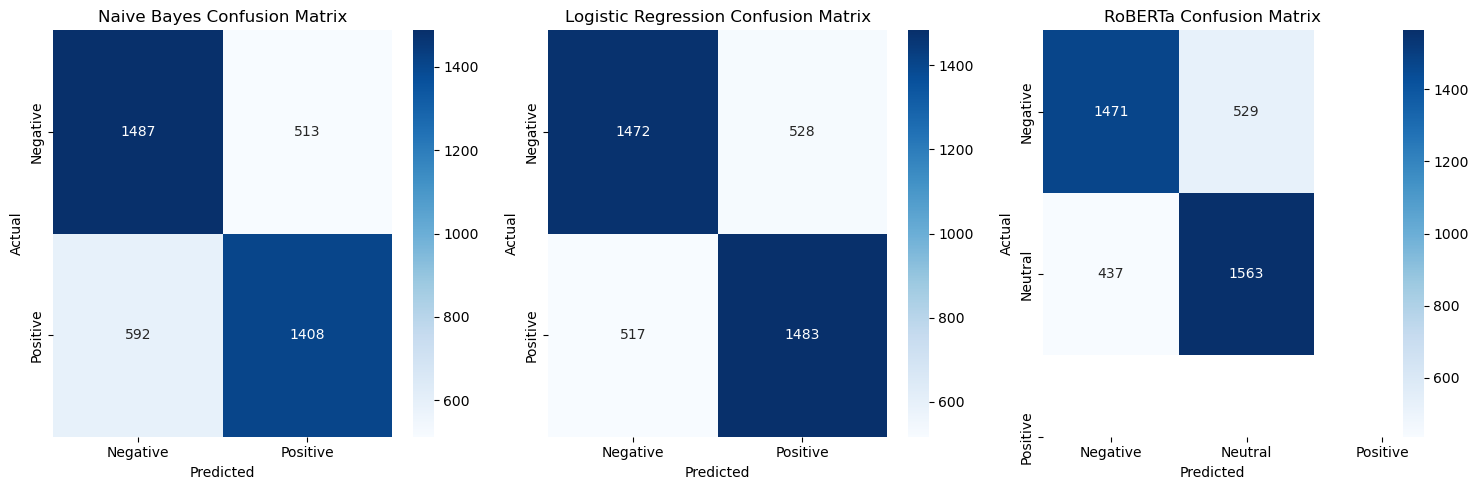

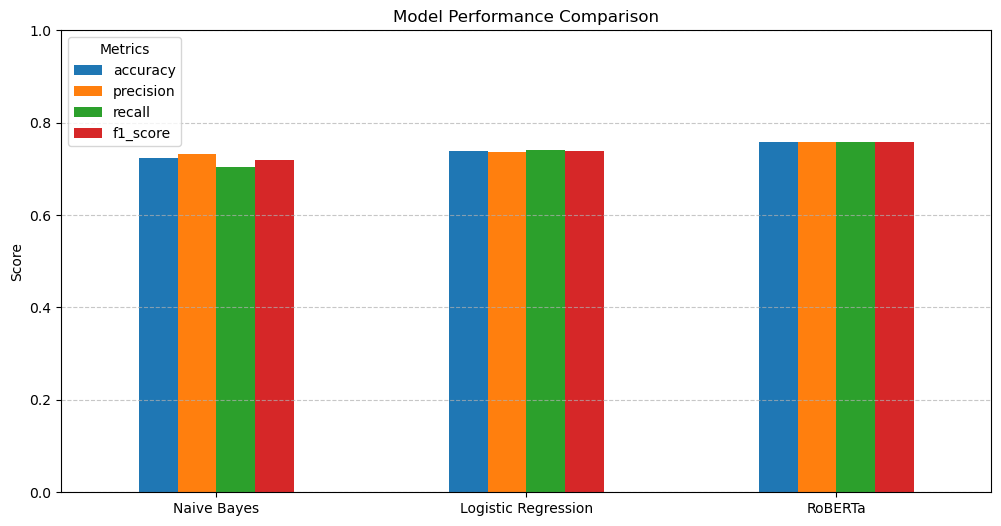

In [21]:
# Plot confusion matrices
plt.figure(figsize=(15, 5))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(1, 3, i+1)
    cm = result['confusion_matrix']
    
    # For RoBERTa, we have 3 classes
    if name == 'RoBERTa':
        labels = ['Negative', 'Neutral', 'Positive']
    else:
        labels = ['Negative', 'Positive']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

# Plot comparative metrics
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
model_names = list(results.keys())

# Create a DataFrame for easy plotting
comparison_df = pd.DataFrame(index=model_names, columns=metrics)
for model in model_names:
    for metric in metrics:
        comparison_df.loc[model, metric] = results[model][metric]

# Bar chart
comparison_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1.0)
plt.legend(title='Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Inference Examples

In [22]:
# Function to run inference with all models
def compare_predictions(text):
    # Clean text for classical models
    cleaned_text = clean_tweet(text)
    
    # Additional features for classical models
    text_len = len(text)
    hashtag_count = len([word for word in text.split() if word.startswith('#')])
    mention_count = len([word for word in text.split() if word.startswith('@')])
    
    # Classical model predictions
    tfidf_vector = tfidf_vectorizer.transform([cleaned_text])
    additional_features = np.array([[text_len, hashtag_count, mention_count]])
    combined_features = hstack([tfidf_vector, additional_features])
    
    # Get predictions from classical models
    nb_prediction = models['Naive Bayes'].predict(combined_features)[0]
    lr_prediction = models['Logistic Regression'].predict(combined_features)[0]
    
    # Convert binary predictions to labels
    nb_label = "Positive" if nb_prediction == 4 else "Negative"
    lr_label = "Positive" if lr_prediction == 4 else "Negative"
    
    # RoBERTa prediction using pipeline
    from transformers import pipeline
    roberta_pipe = pipeline("sentiment-analysis", model=trainer.model, tokenizer=tokenizer)
    roberta_result = roberta_pipe(text)[0]
    roberta_label = roberta_result['label']
    roberta_score = roberta_result['score']
    
    # Print results
    print(f"Text: {text}")
    print(f"Cleaned text: {cleaned_text}")
    print(f"\nModel Predictions:")
    print(f"Naive Bayes: {nb_label}")
    print(f"Logistic Regression: {lr_label}")
    print(f"RoBERTa: {roberta_label} (confidence: {roberta_score:.4f})")
    print("\n" + "-"*50)

# Test with some examples
test_texts = [
    "I absolutely love this product! It's amazing and works perfectly.",
    "This is the worst experience ever. I'm never coming back.",
    "The weather is nice today, but I'm feeling kind of tired.",
    "Just had an awesome lunch with my friends! 😊",
    "@Twitter This update is confusing and hard to use #frustrated"
]

for text in test_texts:
    compare_predictions(text)

Text: I absolutely love this product! It's amazing and works perfectly.
Cleaned text: absolut love product amaz work perfectli

Model Predictions:
Naive Bayes: Positive
Logistic Regression: Positive
RoBERTa: LABEL_2 (confidence: 0.9443)

--------------------------------------------------
Text: This is the worst experience ever. I'm never coming back.
Cleaned text: worst experi ever never come back

Model Predictions:
Naive Bayes: Negative
Logistic Regression: Negative
RoBERTa: LABEL_0 (confidence: 0.9879)

--------------------------------------------------
Text: The weather is nice today, but I'm feeling kind of tired.
Cleaned text: weather nice today feel kind tire

Model Predictions:
Naive Bayes: Negative
Logistic Regression: Negative
RoBERTa: LABEL_0 (confidence: 0.8596)

--------------------------------------------------
Text: Just had an awesome lunch with my friends! 😊
Cleaned text: awesom lunch friend

Model Predictions:
Naive Bayes: Positive
Logistic Regression: Positive
RoBERT

## Save Models for Deployment

In [ ]:
import os

# Create directory for saved models
os.makedirs('./saved_models', exist_ok=True)

# Save classical models
joblib.dump(models['Naive Bayes'], './saved_models/naive_bayes_model.pkl')
joblib.dump(models['Logistic Regression'], './saved_models/logistic_regression_model.pkl')
joblib.dump(tfidf_vectorizer, './saved_models/tfidf_vectorizer.pkl')

# Save preprocessing function for deployment
joblib.dump(clean_tweet, './saved_models/tweet_cleaner.pkl')

# Save RoBERTa model
roberta_path = './saved_models/roberta_model'
trainer.model.save_pretrained(roberta_path)
tokenizer.save_pretrained(roberta_path)

print("All models saved successfully")

All models saved successfully


: 